In [3]:
# import libraries
import tensorflow as tf
import numpy as np

# load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# normalise the data between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

print("Shape of training images:", train_images.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of testing images:", test_images.shape)
print("Shape of testing labels:", test_labels.shape)

Shape of training images: (60000, 28, 28)
Shape of training labels: (60000,)
Shape of testing images: (10000, 28, 28)
Shape of testing labels: (10000,)


In [11]:
train_size = 60000
test_size = 10000

In [4]:
# Reshape data to a column vector for each training example (28 x 28) to (784 x 1)
train_images = train_images.reshape(train_size, 784).T
test_images = test_images.reshape(test_size, 784).T

train_labels = train_labels.reshape((train_size, 1))
test_labels = test_labels.reshape((test_size, 1))

# Convert labels to one hot encoding
one_hot_train_labels = np.zeros((train_size, 10))
one_hot_test_labels = np.zeros((test_size, 10))

for i in range(train_size):
    one_hot_train_labels[i][train_labels[i]] = 1

for i in range(test_size):
    one_hot_test_labels[i][test_labels[i]] = 1

train_labels = one_hot_train_labels.T
test_labels = one_hot_test_labels.T

print("Updated shape of training images:", train_images.shape)
print("Updated shape of training labels:", train_labels.shape)
print("Updated shape of testing images:", test_images.shape)
print("Updated shape of testing labels:", test_labels.shape)

Updated shape of training images: (784, 60000)
Updated shape of training labels: (10, 60000)
Updated shape of testing images: (784, 10000)
Updated shape of testing labels: (10, 10000)


In [7]:
# Initialise model parameters

w1 = np.random.randn(32, 784) * np.sqrt(1 / 784)
w2 = np.random.randn(16, 32) * np.sqrt(1 / 32)
w3 = np.random.randn(10, 16) * np.sqrt(1 / 16)

b1 = np.zeros((32, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

In [8]:
# Helper function to perform softmax over a vector x

def softmax_stable(x):
    return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

In [9]:
# Helper function to calculate the derivative of the Relu function on a matrix x

def relu_prime(x):
    return (x > 0).astype(float)

In [10]:
# Helper function to calculate accuracy of y vs y^

def calculate_accuracy(predictions, ground_truth):
    correct_predictions = np.equal(predictions, ground_truth)
    accuracy = np.mean(correct_predictions)
    return accuracy

In [14]:
def predict(x):
    a1 = np.matmul(w1, x) + b1
    z1 = np.maximum(a1, 0)
    
    a2 = np.matmul(w2, z1) + b2
    z2 = np.maximum(a2,0)

    a3 = np.matmul(w3, z2) + b3
    z3 = np.apply_along_axis(softmax_stable, axis = 0, arr = a3)

    return z3

In [16]:
# Define the training loop
epochs = 50
batch_size = 300
learning_rate = 0.01

X_train = train_images
y_train = train_labels

X_test = test_images
y_test = test_labels

for epoch in range(epochs):
    for step in range(0, train_size, batch_size):
        # Training batch x and y
        x = X_train[:, step:step+batch_size]
        y = y_train[:, step:step+batch_size]

        # Layer 1
        a1 = np.matmul(w1, x) + b1
        z1 = np.maximum(a1, 0) # Relu

        # Layer 2
        a2 = np.matmul(w2, z1) + b2
        z2 = np.maximum(a2,0) # Relu

        # Layer 3 - output
        a3 = np.matmul(w3, z2) + b3
        z3 = np.apply_along_axis(softmax_stable, axis = 0, arr = a3)

        # Calculate gradients for w3
        dL_da3 = z3 - y
        dL_dw3 = 1/batch_size * np.matmul(dL_da3, z2.T)

        # Calculate gradients for w2
        dL_dz2 = np.matmul(w3.T, dL_da3)
        dL_da2 = np.multiply(dL_dz2, relu_prime(a2))
        dL_dw2 = 1/batch_size * np.matmul(dL_da2, z1.T)

        # Calculate gradients for w1
        dL_dz1 = np.matmul(w2.T, dL_da2)
        dL_da1 = np.multiply(dL_dz1, relu_prime(a1))
        dL_dw1 = 1/batch_size * np.matmul(dL_da1, x.T)

        # Calculate gradients for b3, b2, b1
        dL_db3 = 1/batch_size * np.sum(dL_da3, axis = 1).reshape(10, 1)
        dL_db2 = 1/batch_size * np.sum(dL_da2, axis = 1).reshape(16, 1)
        dL_db1 = 1/batch_size * np.sum(dL_da1, axis = 1).reshape(32, 1)

        # Perform parameter updates
        w3 = w3 - learning_rate * dL_dw3
        w2 = w2 - learning_rate * dL_dw2
        w1 = w1 - learning_rate * dL_dw1

        b3 = b3 - learning_rate * dL_db3
        b2 = b2 - learning_rate * dL_db2
        b1 = b1 - learning_rate * dL_db1

    print(f'current epoch {epoch}')

    # Print average loss on training data
    y_pred_train = predict(X_train)
    loss = -np.log(y_pred_train[y_train.astype(bool)])
    average_loss = np.mean(loss, axis=0)
    print(f'Trainig Loss = {average_loss}')

    # Print accuracy on test set
    y_pred_test = predict(X_test)
    accuracy = calculate_accuracy(np.argmax(y_pred_test, axis=0), np.argmax(y_test, axis=0))
    print(f'Test Accuracy = {accuracy}')

current epoch 0
Trainig Loss = 0.9100041176856386
Test Accuracy = 0.7798
current epoch 1
Trainig Loss = 0.6788779672681283
Test Accuracy = 0.8273
current epoch 2
Trainig Loss = 0.5681702373949813
Test Accuracy = 0.8519
current epoch 3
Trainig Loss = 0.5024651137450333
Test Accuracy = 0.8697
current epoch 4
Trainig Loss = 0.4585688002885628
Test Accuracy = 0.8814
current epoch 5
Trainig Loss = 0.4274029006703414
Test Accuracy = 0.8881
current epoch 6
Trainig Loss = 0.4043210595150706
Test Accuracy = 0.8927
current epoch 7
Trainig Loss = 0.38664642978400826
Test Accuracy = 0.8953
current epoch 8
Trainig Loss = 0.37261349930991766
Test Accuracy = 0.8987
current epoch 9
Trainig Loss = 0.3611328570762691
Test Accuracy = 0.902
current epoch 10
Trainig Loss = 0.35147462190196327
Test Accuracy = 0.9035
current epoch 11
Trainig Loss = 0.3430874673952659
Test Accuracy = 0.9057
current epoch 12
Trainig Loss = 0.33568036185252903
Test Accuracy = 0.9077
current epoch 13
Trainig Loss = 0.32902762692

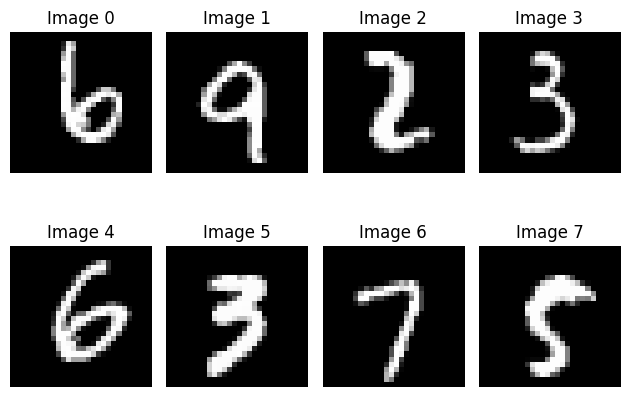

array([6, 9, 2, 3, 6, 3, 7, 5])

In [30]:
# See the results of the trained model

testing_size = 8

from matplotlib import pyplot as plt

random_indices = np.random.choice(test_size, size=testing_size, replace=False)

images = X_test.T.reshape((test_size, 28, 28))
fig, axes = plt.subplots(nrows=2, ncols=4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[random_indices[i]], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Image {i}")

plt.tight_layout()
plt.show()

x = X_test[:, random_indices]
y_pred = predict(x)
np.argmax(y_pred, axis=0)


In [27]:
# Compare our neural network with the one from keras

import tensorflow as tf
from tensorflow.keras import layers

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Create the model
model = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(28 * 28,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/50
422/422 [==============================] - 7s 4ms/step - loss: 0.5579 - accuracy: 0.8439 - val_loss: 0.2214 - val_accuracy: 0.9382
Epoch 2/50
422/422 [==============================] - 1s 3ms/step - loss: 0.2415 - accuracy: 0.9309 - val_loss: 0.1698 - val_accuracy: 0.9572
Epoch 3/50
422/422 [==============================] - 1s 3ms/step - loss: 0.1973 - accuracy: 0.9431 - val_loss: 0.1501 - val_accuracy: 0.9607
Epoch 4/50
422/422 [==============================] - 1s 3ms/step - loss: 0.1692 - accuracy: 0.9509 - val_loss: 0.1407 - val_accuracy: 0.9607
Epoch 5/50
422/422 [==============================] - 1s 3ms/step - loss: 0.1499 - accuracy: 0.9565 - val_loss: 0.1285 - val_accuracy: 0.9642
Epoch 6/50
422/422 [==============================] - 2s 4ms/step - loss: 0.1341 - accuracy: 0.9609 - val_loss: 0.1218 - val_accuracy: 0.9668
Epoch 7/50
422/422 [==============================] - 2s 4ms/step - loss: 0.1209 - accuracy: 0.9646 - val_loss: 0.1211 - val_accuracy: 0.9675
Epoch 